In [3]:
# Import Libraries
import os
import sys
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipykernel
import tweepy
import stockmarket
import nltk
import collections
import seaborn as sns
import itertools
from pathlib import Path

In [3]:
# Read in keys from a csv file
readin_authentication = pd.read_csv('../authentication/authentication_tokens.csv', header=0, sep=',')

consumer_key = readin_authentication['consumer_key'][0]
consumer_secret = readin_authentication['consumer_secret'][0]
access_token = readin_authentication['access_token'][0]
access_token_secret = readin_authentication['access_token_secret'][0]

# connect to twitter application 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
redirect_url = auth.get_authorization_url()
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
def user_download(userID, group):
    tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            tweet_mode = 'extended'
                            )
    all_tweets = []
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    while True:
        tweets = api.user_timeline(screen_name=userID, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            max_id = oldest_id - 1,
                            # Necessary to keep full_text 
                            # otherwise only the first 140 words are extracted
                            tweet_mode = 'extended'
                            )
        if len(tweets) == 0:
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)
        # print('N of tweets downloaded till now {}'.format(len(all_tweets)))
        
    # label and clean up tweets
    outtweets = [[tweet.id_str,
                tweet.created_at, 
                tweet.favorite_count, 
                tweet.retweet_count,
                ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.full_text.encode("utf-8").decode("utf-8")).split()) 
                ] 
                for idx,tweet in enumerate(all_tweets)]
    df_temp = pd.DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])
    
    path = f'../data/{group}'
    if not os.path.exists(path):
        os.makedirs(path)
    df_temp.to_csv(path +'/'+ userID +'_twitter.csv',index=False)

In [23]:
def download_user(user_list, group):
    '''
    # Download users within list of usernames and save in a csv under data
    '''
    for userID in user_list:
        # print(userID)
        user_download(userID, group)
        
# No problem with unvarified user's, no one user can have the same ID
long_term = ['jimcramer','KennethLFisher','AswathDamodaran',\
            'cstewartcfa','lei_zhang_lz', 'realwillmeade',\
                'RayDalio', 'GRDecter', 'BobPisani', 'BobPisani',\
                   'andrewrsorkin',  'EconguyRosie']
short_term = ['DanZanger', 'prrobbins', 'markminervini', 'bsc_daily',\
                'MITickWatcher', 'OptionsProVol', 'script_crypto',\
                'MarketMagnifier', 'TwentyonTwenty_', 'WatcherGuru',\
                'DipFinding','MacroCharts','techbudsolution','DayTradeWarrior',\
                'eWhispers', 'HindenburgRes', 'JehoshaphatRsch','ResearchGrizzly',\
                 'biancoresearch', 'muddywatersre'
                ]
# Download the user's
download_user(short_term, 'short_term')
download_user(long_term, 'long_term')

In [4]:
def merge_files(group, display):
    csv_files = glob.glob(os.path.join('../data'+"/"+group, "*.csv"))
    df = pd.DataFrame()
    i = 0
    for f in csv_files:
        # read the csv file
        df_temp = pd.read_csv(f)
        df_temp['user'] = f.split("\\")[-1].split(".")[0]
        if( display > 0):
            display(df_temp.iloc[0:display])
            print(df_temp.shape)
        # Merging the columns
        df = pd.concat([df_temp,df], names = ['id',	'created_at',	'favorite_count',	'retweet_count', 'text', 'user'])
        i += 1
    print(f"size of merged data sets of {group}: {df.shape}")
    
    path = f'../data/{group}/merge'
    if not os.path.exists(path):
        os.makedirs(path)
    df_temp.to_csv(path +'/merge_'+ group +'_twitter.csv',index=False)
    
    return df 

df_short_term = merge_files('short_term', display = 0)
df_long_term = merge_files('long_term', display = 0)

size of merged data sets of short_term: (46095, 6)
size of merged data sets of long_term: (29015, 6)


In [5]:
# Adding nonessential twitter words
stop = nltk.corpus.stopwords.words("english") 
twitter_nonessential_words = ['twitter', 'birds','lists','list']
stop.extend(twitter_nonessential_words)

In [6]:
def strip_all_words(df, stop):
    '''
    grab all words from every text file, removing spaces and non nessesary words from stop list
    '''
    all_words = df['text'].str.lower().replace(to_replace='(\d)+', value=np.nan,regex=True)
    for i in stop :
        all_words = all_words.replace(to_replace=r'\b%s\b'%i, value=np.nan,regex=True)
    all_words = all_words.str.lower().str.split(' ').explode().dropna()
    counts = all_words.value_counts(
        
    )
    return all_words, counts

In [7]:
all_words_longterm, counts_longterm = strip_all_words(df_long_term, stop)
all_words_shorterm, counts_shorterm = strip_all_words(df_short_term, stop)

nlp_words_long=nltk.FreqDist(all_words_longterm)
nlp_words_short=nltk.FreqDist(all_words_shorterm)

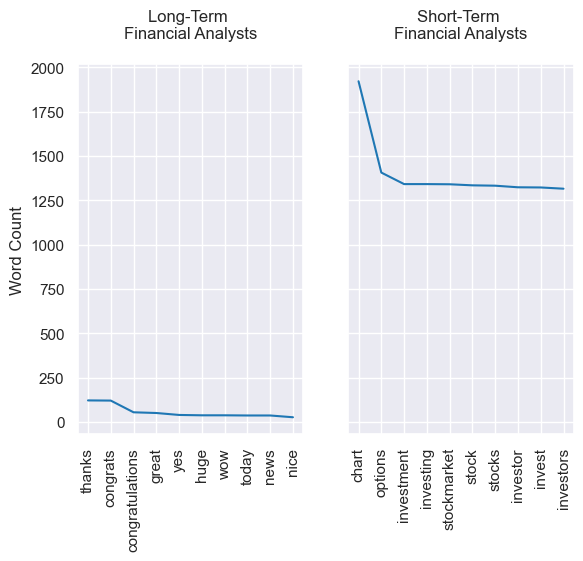

In [56]:
# Top 10 short and Long Term
how_many_samples = 10
sample_long = counts_longterm[0:how_many_samples]
sample_short = counts_shorterm[0:how_many_samples]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
f = sns.lineplot(x = sample_long.index, y = sample_long, ax=ax1)
g = sns.lineplot(x = sample_short.index, y = sample_short, ax=ax2)
f.set(ylabel ="Word Count", title ='Long-Term \nFinancial Analysts\n')
g.set(ylabel ="Word Count", title ='Short-Term \nFinancial Analysts\n')
sns.set_style('darkgrid')
f.tick_params(axis='x', rotation=90)
g.tick_params(axis='x', rotation=90)

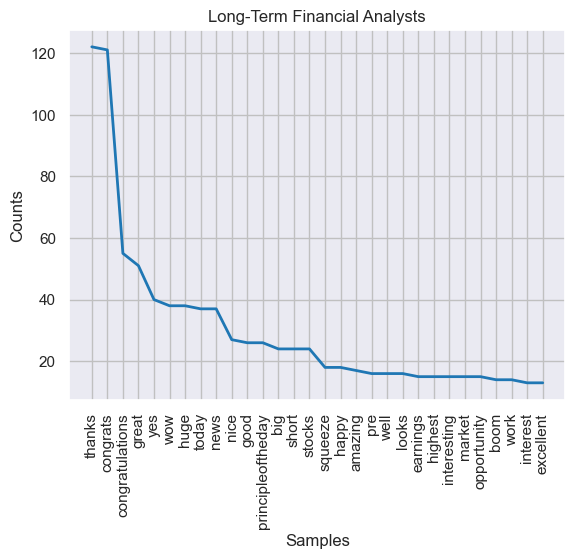

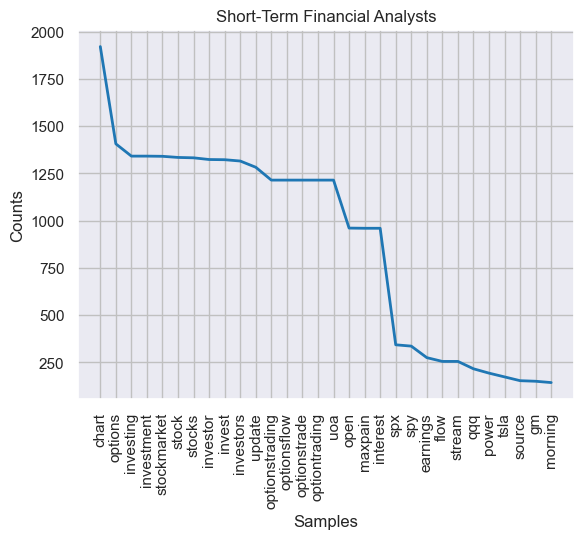

<AxesSubplot:title={'center':'Short-Term Financial Analysts'}, xlabel='Samples', ylabel='Counts'>

In [57]:
nlp_words_long.plot(30, title='Long-Term Financial Analysts')
nlp_words_short.plot(30, title='Short-Term Financial Analysts')

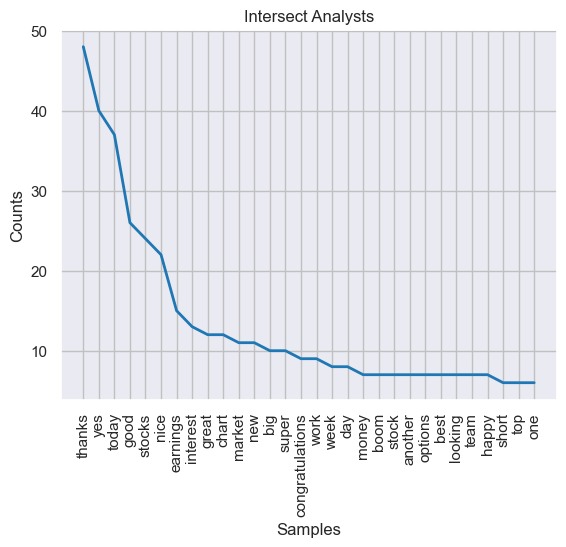

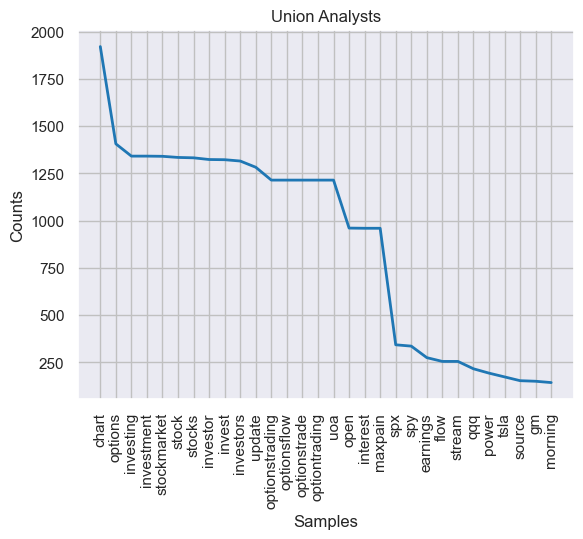

<AxesSubplot:title={'center':'Union Analysts'}, xlabel='Samples', ylabel='Counts'>

In [124]:
df_short_intersect = nlp_words_long & nlp_words_short
df_short_union = nlp_words_long | nlp_words_short
df_short_difference_long = nlp_words_long - nlp_words_short
df_short_difference_short = nlp_words_short - nlp_words_long

df_short_intersect.plot(30, title='Intersect Analysts')
df_short_union.plot(30, title='Union Analysts')